<a href="https://colab.research.google.com/github/DaliaAlzubi/Kidney_Tumor/blob/main/Tumer_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## steps : 

1. read Data (excel file ) from google drive , images 
2. unzip images file
3. read images 
4. preparation
4. split data to  taring 80 % , testing 20%
5. normalization images
6. building model
7. compile model 
8. fit model 
9. test model
10. Plot the results

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import seaborn as sns; sns.set(color_codes=True)  # visualization tool
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import os
import statistics
import collections
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from datetime import datetime
from datetime import date
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix
from IPython.display import display 
from sklearn.ensemble import AdaBoostClassifier
import keras
from keras.models import Sequential , Model
from keras.layers import (
                          Dense,
                          Add,
                          Conv2D,
                          MaxPool2D,
                          Flatten,
                          Dropout,
                          MaxPooling2D,
                          Input,
                          Conv2DTranspose,
                          Concatenate,
                          BatchNormalization,
                          UpSampling2D,
                          AveragePooling2D,
                          GlobalAveragePooling2D,
                          Activation,
                          ZeroPadding2D
                      )
from keras.preprocessing.image import ImageDataGenerator
#from keras.optimizers import Adam , SGD
from keras.layers.merge import concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras import backend as K
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from sklearn.metrics import classification_report,confusion_matrix
from PIL import Image
import tensorflow as tf
import glob
import random
import cv2
from random import shuffle
import itertools
import shutil
from tensorflow.keras.models import Model, load_model
import imutils
from tensorflow.keras import optimizers
import cv2 as cv
import seaborn as sns
from random import choices
from keras.applications.vgg16 import VGG16 
#from keras.applications.resnet50 import ResNet50
from keras.applications.resnet import ResNet50

from keras.initializers import glorot_uniform

In [ ]:
!unzip sample_data/images_data.zip -d sample_data/

Streaming output truncated to the last 5000 lines.
  inflating: sample_data/Dalia_Data/35/00000125.jpg  
  inflating: sample_data/Dalia_Data/35/00000126.jpg  
  inflating: sample_data/Dalia_Data/35/0000012B.jpg  
  inflating: sample_data/Dalia_Data/35/0000012E.jpg  
  inflating: sample_data/Dalia_Data/35/0000012F.jpg  
  inflating: sample_data/Dalia_Data/35/0000014B.jpg  
  inflating: sample_data/Dalia_Data/35/0000014D.jpg  
  inflating: sample_data/Dalia_Data/35/0000014F.jpg  
  inflating: sample_data/Dalia_Data/35/00000151.jpg  
  inflating: sample_data/Dalia_Data/35/00000152.jpg  
  inflating: sample_data/Dalia_Data/35/0000018B.jpg  
  inflating: sample_data/Dalia_Data/35/0000018C.jpg  
  inflating: sample_data/Dalia_Data/35/0000019E.jpg  
  inflating: sample_data/Dalia_Data/35/000001A1.jpg  
  inflating: sample_data/Dalia_Data/35/000001A4.jpg  
  inflating: sample_data/Dalia_Data/35/000001A5.jpg  
  inflating: sample_data/Dalia_Data/35/000001A6.jpg  
  inflating: sample_data/Dalia_

# Read Data 

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
patient_info = drive.CreateFile({'id':"1cWmJm6-MPhhDMxhkBnQzMnANjVofmdG_"})
patient_info.GetContentFile("patient_info.csv")
patient_info = pd.read_csv("patient_info.csv")

# Tumor Detection

In [ ]:
patient_info["Tumor_label"]= patient_info["Tumor_Type"]
cleanup_nums = {
    "Tumor_label":{'Null':0  , "Benign":1 , 'Malignant':1 }
}
patient_info = patient_info.replace(cleanup_nums)
del cleanup_nums

In [ ]:
patient_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 23 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   Patient_ID                       120 non-null    object
 1   Patient_Num                      120 non-null    int64 
 2   Age                              120 non-null    int64 
 3   Gender                           120 non-null    object
 4   Test                             120 non-null    object
 5   Date                             120 non-null    int64 
 6   Taking_Contrast                  120 non-null    object
 7   Clinical_data                    120 non-null    object
 8   Symptoms                         120 non-null    object
 9   Diagnosing_test                  120 non-null    object
 10  Diagnosing_Right_Kidney          120 non-null    object
 11  Injure_range_Right_K_in_Details  120 non-null    object
 12  Segmentation_Right               120

In [ ]:
patient_info.sample(5)

,Patient_ID,Patient_Num,Age,Gender,Test,Date,Taking_Contrast,Clinical_data,Symptoms,Diagnosing_test,Diagnosing_Right_Kidney,Injure_range_Right_K_in_Details,Segmentation_Right,Diagnosing_Left_Kidney,Injure_range_Left_K_in_Details,Segmentation_Left,Stage,Situation,Tumor_Type,Tumor_Class,Segmentation_Right_Label,Segmentation_Left_Label,Tumor_label
39,KA00109056,40,55,Male,CT ABDOMEN PELVIS,2021,Yes,Right nephroectomy RCC,Not provided,"Small cyst in left kidney , Stable disease",Nephrectomy,Non visulaliz nephrectomy,Undefined,Cyst,Small cyst 1.2 x 1 cm,Midportion,I,Tumor,Malignant,RCC,Undefined,Healthy,1
66,KA00157061,67,70,Male,CT ABDOMEN PELVIS,2020,Yes,Cancer big toe,Not provided,"Lesions liver 3.3 x 4.2 cm and 4.2 x 4.7 cm,",Cyst,cyst 1.9 x 1.7 cm,Upper pole,Healthy,Healthy,Undefined,Null,Normal case with cyst,Null,Null,NaN,NaN,0
70,KA00202545,71,55,Female,CT ABDOMEN PELVIS,2020,Yes,Umbilical hernia,Abdomen pain,Large uncomplicated umbilical hernia containin...,Cyst,Cyst 1 x 0.8 cm,Midpole,Healthy,Healthy,Undefined,Null,Normal case with cyst,Null,Null,NaN,NaN,0
99,KA00015215,100,52,Female,CT ABDOMEN PELVIS,2020,Yes,Lleft partial nephrectomy RCC,Abdomen pain,"Tiny renal cyst, small lesion liver",Cyst,Tiny renal cyst,Undefined,Nephrectomy,"Non-visualize, radical nephrectomy",Undefined,Null,Normal case,Null,Null,NaN,NaN,0
110,KA00123219,111,67,Female,CT ABDOMEN PELVIS,2021,No,Not provided,Not provided,"Cyst in pelvis, liver fat",Stone,Stone 0.6 cm,Lower calyceal,Renal cortical scar,Renal cortical scar,Undefined,Null,Normal case,Null,Null,NaN,NaN,0


In [ ]:
def crop_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # Threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
  
    # Find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()

        plt.subplot(1, 2, 1)
        plt.imshow(image)
        
        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)

        plt.tick_params(axis='both', which='both', 
                        top=False, bottom=False, left=False, right=False,
                        labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [ ]:
labels = {0:"Normal" , 1:"Tumor"}

In [ ]:
def get_data (data_dir , target ):
    X = list()
    y=list()
    img_size = 256
    for index, row in patient_info.iterrows():
        path = os.path.join(data_dir, str (row['Patient_Num']))
        label = row[target]
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img))[...,::-1] 
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size   
                
                X.append(resized_arr)
                y.append(label)
            except Exception as e:
                print(e , row['Patient_Num'] )
    return X , y

X , y  = get_data("sample_data/Dalia_Data/", target = "Tumor_label")

In [ ]:
dict(zip(list(y),[list(y).count(i) for i in list(y)]))

{0: 4200, 1: 4200}

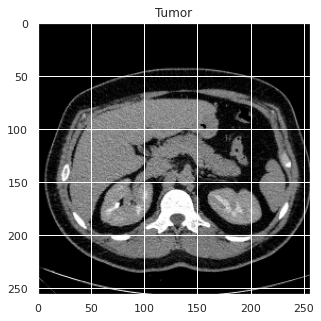

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[20])
plt.title(labels[y[20]])
plt.show()

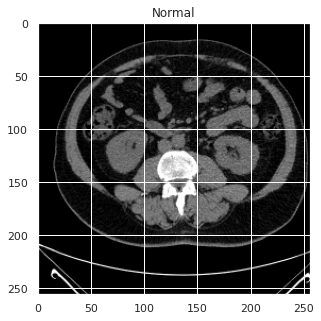

In [ ]:
plt.figure(figsize = (5,5))
plt.imshow(X[6000])
plt.title(labels[y[6000]])
plt.show()

In [ ]:
x_train, x_test, y_train , y_test = train_test_split(X, y, test_size = 0.20)
x_train, x_val , y_train , y_val = train_test_split(x_train, y_train , test_size = 0.20)

In [ ]:
print ("Number images for training : {}".format(len (x_train)) , dict(zip(list(y_train),[list(y_train).count(i) for i in list(y_train)])) )
print ("Number images for testing : {}".format(len (x_test)), dict(zip(list(y_test),[list(y_test).count(i) for i in list(y_test)])) )
print ("Number images for Validation : {}".format(len (x_val)) ,  dict(zip(list(y_val),[list(y_val).count(i) for i in list(y_val)])) )

Number images for training : 5376 {0: 2679, 1: 2697}
Number images for testing : 1680 {0: 848, 1: 832}
Number images for Validation : 1344 {1: 671, 0: 673}


In [ ]:
def data_prepare (X , y , folder_name , labels ) :
    path = "sample_data/{}".format(folder_name)
    os.mkdir(path)
    # create folder for labels 
    for key , value in labels.items()  : 
        path = "sample_data/{}/{}".format(folder_name,value)
        os.mkdir(path)

    if len (X) != len (y) : 
      print ("error size data X and y is not equal")
      return 

    for index , value in enumerate(y) : 
      im = Image.fromarray(X[index])
      path = "sample_data/{}/{}/{}.jpeg".format(folder_name,labels[value],str(index))
      im.save(path)
    return 

In [ ]:
data_prepare (X=x_train ,y=y_train ,folder_name="train", labels=labels )
data_prepare (X=x_test ,y=y_test ,folder_name="test", labels=labels )
data_prepare (X=x_val ,y=y_val ,folder_name="validation", labels=labels )

In [ ]:
## Genration Images 

train_datagen = ImageDataGenerator(shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator()

training_set = train_datagen.flow_from_directory('/content/sample_data/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

validation_set = validation_datagen.flow_from_directory('/content/sample_data/validation',
                                            target_size = (224,224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 5376 images belonging to 2 classes.
Found 1344 images belonging to 2 classes.


# my model

In [ ]:
class AccuracyStopping(keras.callbacks.Callback):
    def __init__(self, acc_threshold):
        super(AccuracyStopping, self).__init__()
        self._acc_threshold = acc_threshold

    def on_epoch_end(self, batch, logs={}):
        train_acc = logs.get('accuracy')
        print(train_acc)
        value=1-train_acc
        print(value)
        self.model.stop_training = value <= self._acc_threshold

acc_callback = AccuracyStopping(0.02)

def get_Model():
    modelName= Sequential()
    modelName.add(BatchNormalization(input_shape = (224,224,3)))
    modelName.add(Conv2D(32, (3, 3), input_shape = (224, 224, 3), activation = 'relu'))
    modelName.add(MaxPooling2D(pool_size = (2, 2)))
    modelName.add(Dropout(0.25))
    modelName.add(Flatten())
    modelName.add(Dense(units = 128, activation = 'relu'))
    modelName.add(Dense(units = 2, activation = 'softmax'))
    return modelName

x=get_Model()

x.compile(
    optimizer='adam' , 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']    )

history = x.fit(    
          training_set,
          steps_per_epoch = (5376 /32),
          epochs=50, 
          validation_data=validation_set,
          validation_steps = (1344/32)
                          )

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


168/168 [==============================] - 80s 373ms/step - loss: 4.3987 - accuracy: 0.5887 - val_loss: 1.7223 - val_accuracy: 0.5766
Epoch 2/50
168/168 [==============================] - 62s 369ms/step - loss: 0.8593 - accuracy: 0.6514 - val_loss: 0.9561 - val_accuracy: 0.6354
Epoch 3/50
168/168 [==============================] - 62s 371ms/step - loss: 0.6434 - accuracy: 0.6830 - val_loss: 0.6826 - val_accuracy: 0.6935
Epoch 4/50
168/168 [==============================] - 65s 385ms/step - loss: 0.5675 - accuracy: 0.7191 - val_loss: 0.6613 - val_accuracy: 0.7195
Epoch 5/50
168/168 [==============================] - 64s 382ms/step - loss: 0.5375 - accuracy: 0.7329 - val_loss: 0.7739 - val_accuracy: 0.7054
Epoch 6/50
168/168 [==============================] - 64s 383ms/step - loss: 0.5272 - accuracy: 0.7385 - val_loss: 0.5299 - val_accuracy: 0.7418
Epoch 7/50
168/168 [==============================] - 64s 381ms/step - loss: 0.5071 - accuracy: 0.7558 - val_loss: 0.5286 - val_accuracy: 0.7

In [ ]:
x.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization (BatchNo (None, 224, 224, 3)       12        
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
flatten (Flatten)            (None, 394272)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               50466944  
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Validation Set Clases : ' , validation_set.class_indices )

Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Validation Set Clases :  {'Normal': 0, 'Tumor': 1}


In [ ]:
loss,accuracy=x.evaluate(validation_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

42/42 [==============================] - 3s 62ms/step - loss: 0.1480 - accuracy: 0.9531
Test Loss     = 0.14795348048210144
Test Accuracy = 0.953125


<Figure size 1080x1080 with 0 Axes>

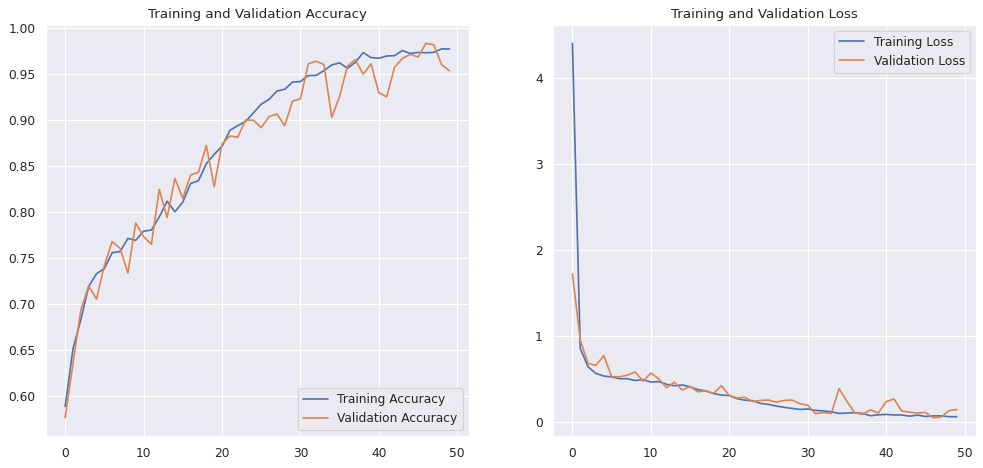

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))

fig, ax = plt.subplots(figsize = (15 ,15) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')  
ax.spines['bottom'].set_color('#000000')

plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Number of images for Normal : 848


'=============================='

{'Normal': 823, 'Tumor': 25}

'=============================='

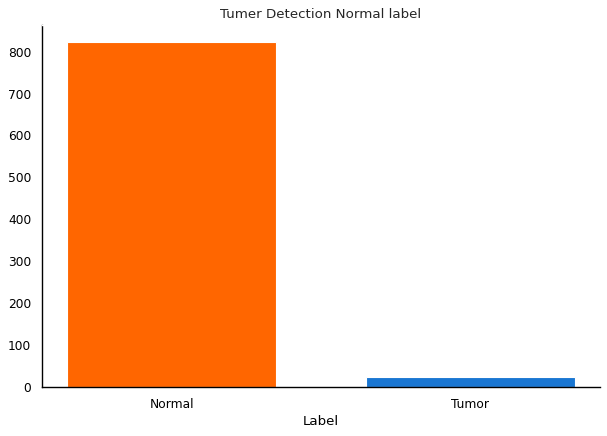

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


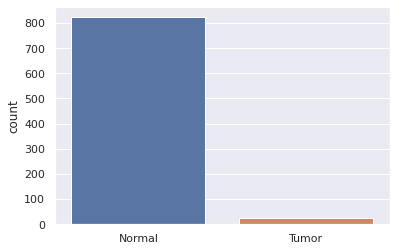

In [ ]:
from keras.preprocessing import image
color=['#ff6600','#1976D2'] 

path='/content/sample_data/test/Normal'
l_Normal =[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

l_Normal_result=[]
for i in range(len(l_Normal)):
  xx = x.predict(l_Normal[i])
  xx = np.round(xx).astype(int)
  l_Normal_result.append(xx[0][1])

l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i]== 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)

res = dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)]))
labels = ['Normal','Tumor']

fig, ax = plt.subplots(figsize = (9 , 6) , dpi=80,)
ax.set_facecolor('#ffffff')
ax.xaxis.label.set_color('#000000')
ax.yaxis.label.set_color('#000000')
ax.tick_params(axis='x', colors='#000000' )  
ax.tick_params(axis='y', colors='#000000')
ax.spines['left'].set_color('#000000')        # setting up Y-axis tick color to red
ax.spines['bottom'].set_color('#000000')
plt.bar( labels , res.values() ,width = 0.7,  color=[ '#ff6600', '#1976D2'] ,  align='center' , zorder=1)
plt.xlabel('Label')
plt.title('Tumer Detection Normal label')
plt.show()


sns.set_style('darkgrid')
sns.countplot(l_Normal_draw)
plt.show()


Number of images for Tumor : 832


'=============================='

{'Normal': 31, 'Tumor': 801}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


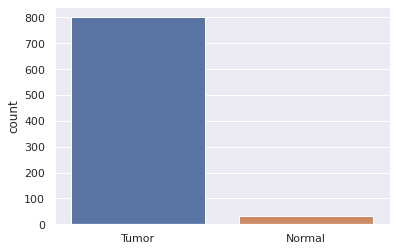

In [ ]:
from keras.preprocessing import image

path='/content/sample_data/test/Tumor'
l_Tumor=[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

l_Tumor_result=[]
for i in range(len(l_Tumor)):
  #xx = x.predict_classes(l_Tumor[i]
  xx = x.predict(l_Tumor[i])
  xx = np.round(xx).astype(int)
  l_Tumor_result.append(xx[0][1])

l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Tumor_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(validation_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Normal       0.96      0.97      0.97       848
       Tumor       0.97      0.96      0.97       832

    accuracy                           0.97      1680
   macro avg       0.97      0.97      0.97      1680
weighted avg       0.97      0.97      0.97      1680



In [ ]:
x.save('/content/drive/MyDrive/Tumer_classification/best_model.h5')

# ResNet50

In [ ]:
#add RESNet Model as a layer in ou model as we use in the structure above 

stop = EarlyStopping(
    monitor='val_accuracy', 
    mode='max',
    patience=6
)

base_model_2 = Sequential()
base_model_2.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model_2.add(Dropout(0.25))
base_model_2.add(Flatten())
base_model_2.add(Dense(units = 128, activation = 'relu'))
base_model_2.add(Dense(2, activation='softmax'))


base_model_2.compile(
    optimizer='adam' , 
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    metrics=['accuracy']    )


94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
base_model_2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 2048)              23587712  
_________________________________________________________________
dropout_2 (Dropout)          (None, 2048)              0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               262272    
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 258       
Total params: 23,850,242
Trainable params: 23,797,122
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
history=base_model_2.fit(training_set,validation_data=validation_set,epochs=50,callbacks=[stop])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4907: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`sparse_categorical_crossentropy` received `from_logits=True`, but '


168/168 [==============================] - 73s 395ms/step - loss: 0.9494 - accuracy: 0.6416 - val_loss: 0.6969 - val_accuracy: 0.6042
Epoch 2/50
168/168 [==============================] - 65s 387ms/step - loss: 0.4403 - accuracy: 0.8021 - val_loss: 1.0043 - val_accuracy: 0.6667
Epoch 3/50
168/168 [==============================] - 65s 384ms/step - loss: 0.2918 - accuracy: 0.8813 - val_loss: 0.4175 - val_accuracy: 0.8772
Epoch 4/50
168/168 [==============================] - 65s 385ms/step - loss: 0.2553 - accuracy: 0.8962 - val_loss: 0.2891 - val_accuracy: 0.8824
Epoch 5/50
168/168 [==============================] - 65s 386ms/step - loss: 0.1894 - accuracy: 0.9299 - val_loss: 0.8496 - val_accuracy: 0.7463
Epoch 6/50
168/168 [==============================] - 65s 384ms/step - loss: 0.1747 - accuracy: 0.9304 - val_loss: 0.2303 - val_accuracy: 0.9293
Epoch 7/50
168/168 [==============================] - 65s 387ms/step - loss: 0.1557 - accuracy: 0.9444 - val_loss: 0.2437 - val_accuracy: 0.9

In [ ]:
print('Training Set Clases : ', training_set.class_indices )
print("=="*10)
print('Validation Set Clases : ' , validation_set.class_indices )


Training Set Clases :  {'Normal': 0, 'Tumor': 1}
Validation Set Clases :  {'Normal': 0, 'Tumor': 1}


In [ ]:
loss,accuracy=base_model_2.evaluate(validation_set)
print (f"Test Loss     = {loss}")
print (f"Test Accuracy = {accuracy}")

42/42 [==============================] - 3s 70ms/step - loss: 0.0806 - accuracy: 0.9747
Test Loss     = 0.08058987557888031
Test Accuracy = 0.9747023582458496


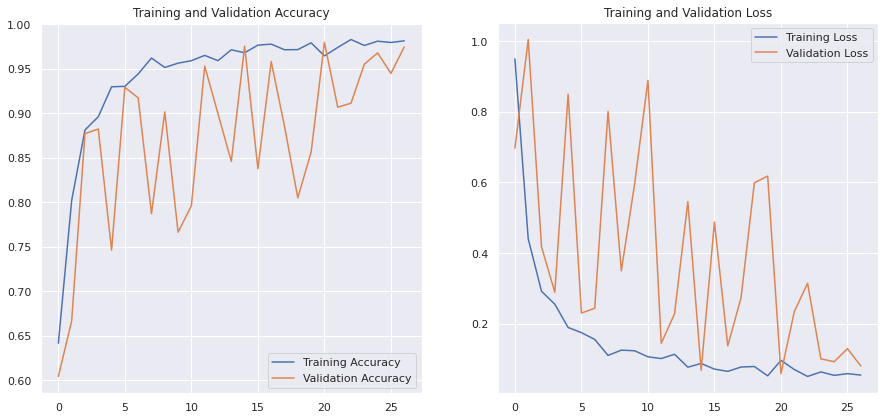

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 2, 1)
plt.plot( acc, label='Training Accuracy')
plt.plot( val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 2, 2)
plt.plot( loss, label='Training Loss')
plt.plot( val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Number of images for Normal : 848


'=============================='

{'Normal': 806, 'Tumor': 42}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


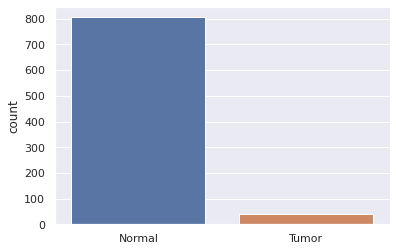

In [ ]:
from keras.preprocessing import image

path='/content/sample_data/test/Normal'
l_Normal =[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Normal =[0]*len(filelist)
print ("Number of images for Normal :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Normal.append(test_image)

l_Normal_result=[]
for i in range(len(l_Normal)):
  xx= base_model_2.predict(l_Normal[i])
  xx = np.round(xx).astype(int)
  l_Normal_result.append(xx[0][1])


l_Normal_draw=[]
for i in range(len(l_Normal_result)):
    if (l_Normal_result[i] == 0):
        l_Normal_draw.append("Normal")
    else :
        l_Normal_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Normal_draw),[list(l_Normal_draw).count(i) for i in list(l_Normal_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Normal_draw)
plt.show()

In [ ]:
xx

array([[1, 0]])

Number of images for Tumor : 832


'=============================='

{'Normal': 19, 'Tumor': 813}

'=============================='

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


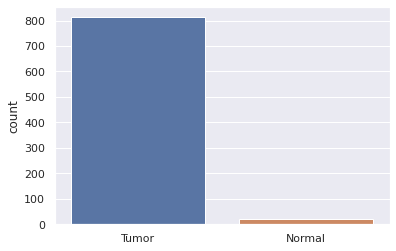

In [ ]:
from keras.preprocessing import image

path='/content/sample_data/test/Tumor'
l_Tumor=[]

filelist= [file for file in os.listdir(path) if file.endswith('.jpeg')]
y_Tumor =[1]*len(filelist)
print ("Number of images for Tumor :" , len (filelist))

for img in filelist:
  test_image = image.load_img(os.path.join(path, img),target_size = (224, 224))
  test_image = image.img_to_array(test_image)
  test_image = np.expand_dims(test_image, axis = 0)
  l_Tumor.append(test_image)

l_Tumor_result=[]
for i in range(len(l_Tumor)):
  xx= base_model_2.predict(l_Tumor[i])
  xx = np.round(xx).astype(int)
  l_Tumor_result.append(xx[0][1])

l_Tumor_draw=[]
for i in range(len(l_Tumor_result)):
    if (l_Tumor_result[i]== 0):
        l_Tumor_draw.append("Normal")
    else :
        l_Tumor_draw.append("Tumor")

display('==='*10)
display(dict(zip(list(l_Tumor_draw),[list(l_Tumor_draw).count(i) for i in list(l_Tumor_draw)])))
display('==='*10)

sns.set_style('darkgrid')
sns.countplot(l_Tumor_draw)
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

print('Training Set Clases')
print(training_set.class_indices)
print('Testing Set Clases')
print(validation_set.class_indices)
print("======"*10)
print('\nConfusion Matrix')
print('Classification Report')
target_names = ['Normal', 'Tumor']

y_labels  = y_Normal +y_Tumor
x_results = l_Normal_result + l_Tumor_result
print(classification_report( y_labels , x_results , target_names=target_names))

Training Set Clases
{'Normal': 0, 'Tumor': 1}
Testing Set Clases
{'Normal': 0, 'Tumor': 1}

Confusion Matrix
Classification Report
              precision    recall  f1-score   support

      Normal       0.98      0.95      0.96       848
       Tumor       0.95      0.98      0.96       832

    accuracy                           0.96      1680
   macro avg       0.96      0.96      0.96      1680
weighted avg       0.96      0.96      0.96      1680

